## Note au jury — couverture de dérivés

Notebook consacré aux techniques de hedging (delta/gamma) sur options. Les notes clarifient le cadre, les hypothèses et les métriques de suivi.


# Hedging de dérivés : rappel et implémentation

Nous illustrons la réplication d'options via couverture dynamique. Hypothèses de base : BSM, marché frictionless (sauf mention). Les sections détaillent le calcul des greeks, la mise à jour du portefeuille et l'impact des paramètres.


## Plan d'analyse

- Calcul des greeks (delta, gamma, vega) pour un call européen.
- Stratégie de couverture : ajustement discret, suivi PnL.
- Sensibilités : effets de la volatilité, du pas de temps, des coûts.


<a id='0'></a>
# 1. Problem Definition

In the Reinforcement Learning based framework for this case study, the algorithm decides the best hedging strategy for call options from the market prices of the underlying asset based on direct policy search reinforcement learning. 

The key components of the Reinforcement Learning framework used for this case study are described below:

* Agent: Trader or a trading agent
* Action: Hedging strategy (i.e. δ1, δ2 . . , δT)
* Reward function: CVaR is used as the reward function for this case study. This is a convex function and is minimized during the model training.

* State: State is the representation of the current market state and relevant product state variables. The state represent the model inputs which are Stock Price Path
(i.e. S1, S2 . . , ST), strike and risk aversion parameter(α)

* Environment: Stock exchange or the stock market.



<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
#import seaborn as sns




# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import random
import scipy.stats as stats

from IPython.core.debugger import set_trace

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
import tensorflow as tf

from collections import namedtuple, deque

D:\Programmes\Anaconda\envs\NLP_Finance\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.2'></a>
## 2.2. Generating the Data 

The function below generates the monte-carlo paths for the stock price and get the option price on each of the monte-carlo path.

### Black-Sholes Simulation
Simulate $N_{MC}$ stock price sample paths with $T$ steps by the classical Black-Sholes formula.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$


In [3]:
def monte_carlo_paths(S_0, time_to_expiry, sigma, drift, seed, n_sims, n_timesteps):
    """
    Create random paths of a underlying following a browian geometric motion
    
    input:
    
    S_0 = Spot at t_0
    time_to_experiy = end of the timeseries (last observed time)
    sigma = the volatiltiy (sigma in the geometric brownian motion)
    drift = drift of the process
    n_sims = number of paths to generate
    n_timesteps = numbers of aquidistant time steps 
    
    return:
    
    a (n_timesteps x n_sims x 1) matrix
    """
    if seed > 0:
            np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, n_timesteps)
    S = S_0
    dt = time_to_expiry / stdnorm_random_variates.shape[1]
    r = drift
    # See Advanced Monte Carlo methods for barrier and related exotic options by Emmanuel Gobet
    S_T = S * np.cumprod(np.exp((r-sigma**2/2)*dt+sigma*np.sqrt(dt)*stdnorm_random_variates), axis=1)
    return np.reshape(np.transpose(np.c_[np.ones(n_sims)*S_0, S_T]), (n_timesteps+1, n_sims, 1))

In [4]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed = 42
n_sims = 50000

In [5]:
# Train the model on the path of the risk neutral measure
paths_train = monte_carlo_paths(S_0, T, vol, r, seed, n_sims, timesteps)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Plot Paths

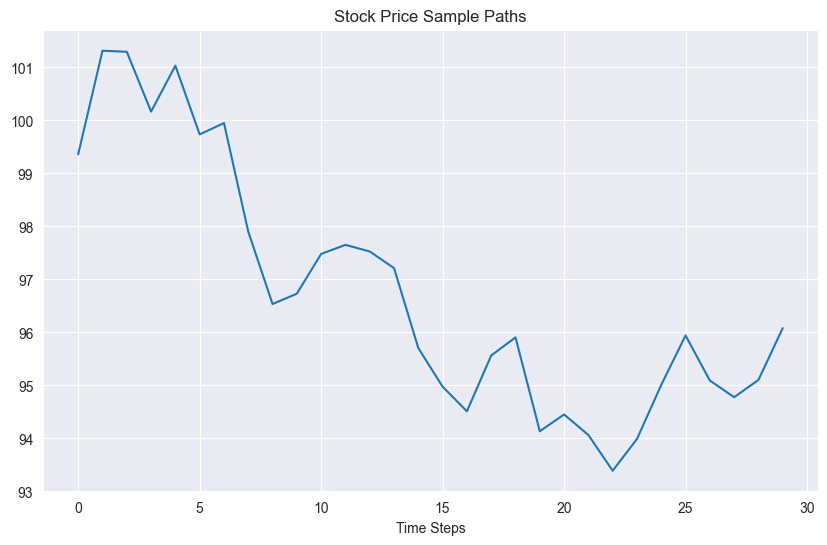

In [6]:
#Plot Paths for one simulation
plt.figure(figsize=(10,6))
plt.plot(paths_train[1:31,1])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


<a id='4'></a>
# 4. Evaluate Algorithms and Models

The approach used in the case study is Policy Gradient which is a type of Direct Policy Search (or policy-based) algorithm. In this approach we use LSTM model to map the state to action. 

<a id='4.1'></a>
## 4.1. Policy Gradient script
In this step we implement in the RL “Agent” class. Agent holds the variables and member functions that perform the training. An
object of the “Agent” class is created using the training phase and is used for training
the model. After sufficient number of iterations policy
gradient model is generated.
The “class” consists of two modules:

* Constructor
* Function execute_graph_batchwise

In [7]:
from IPython.core.debugger import set_trace
import tensorflow as tf

tf.compat.v1.disable_eager_execution()



class Agent(object):
    def __init__(self, time_steps, batch_size, features, nodes = [62,46,46,1], name='model'):

        #tf.reset_default_graph()
        self.batch_size = batch_size #NUmber of options in a batch
        self.S_t_input = tf.compat.v1.placeholder(tf.float32, [time_steps, batch_size, features]) #Spot
        self.K = tf.compat.v1.placeholder(tf.float32, batch_size) #Strike
        self.alpha = tf.compat.v1.placeholder(tf.float32) #alpha for cVaR

        S_T = self.S_t_input[-1,:,0] #Spot at time T
        dS = self.S_t_input[1:, :, 0] - self.S_t_input[0:-1, :, 0] # Change in the Spot price
        #dS = tf.reshape(dS, (time_steps, batch_size))

        #Prepare S_t for the use in the RNN remove the last time step (at T the portfolio is zero)
        S_t = tf.unstack(self.S_t_input[:-1, :,:], axis=0)

        # Utiliser RNN de manière compatible avec TF 2.x
        # Créer un modèle RNN avec des cellules LSTM empilées
        inputs = tf.transpose(self.S_t_input[:-1, :, :], [1, 0, 2])  # Réorganiser pour (batch, time, features)

        # Créer un modèle séquentiel pour les cellules LSTM
        lstm_model = tf.keras.Sequential()

        # Ajouter les couches LSTM
        for i, n in enumerate(nodes[:-1]):
            return_sequences = (i < len(nodes) - 2)
            if i == 0:
                lstm_model.add(tf.keras.layers.LSTM(n, return_sequences=return_sequences,
                                                    input_shape=(time_steps - 1, features)))
            else:
                lstm_model.add(tf.keras.layers.LSTM(n, return_sequences=return_sequences))

        # Ajouter la dernière couche Dense
        lstm_model.add(tf.keras.layers.Dense(nodes[-1]))

        # Appliquer le modèle aux entrées
        outputs = lstm_model(inputs)

        # Réorganiser les sorties si nécessaire
        self.strategy = tf.transpose(outputs, [1, 0])  # (time_steps-1, batch_size)

        self.option = tf.maximum(S_T-self.K, 0)

        self.Hedging_PnL = - self.option + tf.reduce_sum(dS*self.strategy, axis=0)
        self.Hedging_PnL_Paths = - self.option + dS*self.strategy

        # Calculate the CVaR for a given confidence level alpha
        # Take the 1-alpha largest losses (top 1-alpha negative PnLs) and calculate the mean
        CVaR, idx = tf.nn.top_k(-self.Hedging_PnL, tf.cast((1-self.alpha)*batch_size, tf.int32))
        CVaR = tf.reduce_mean(CVaR)

        optimizer = tf.compat.v1.train.AdamOptimizer()
        self.train = optimizer.minimize(CVaR, var_list=tf.compat.v1.trainable_variables())



        self.saver = tf.compat.v1.train.Saver()
        self.modelname = name

    def _execute_graph_batchwise(self, paths, strikes, riskaversion, sess, epochs=1, train_flag=False):
        sample_size = paths.shape[1]
        batch_size=self.batch_size
        idx = np.arange(sample_size)
        start = dt.datetime.now()
        for epoch in range(epochs):
            # Save the hedging Pnl for each batch
            pnls = []
            strategies = []
            if train_flag:
                np.random.shuffle(idx)
            for i in range(int(sample_size/batch_size)):
                indices = idx[i*batch_size : (i+1)*batch_size]
                batch = paths[:,indices,:]
                if train_flag:#runs the train, hedging PnL and strategy using the inputs
                    _, pnl, strategy = sess.run([self.train, self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                          self.K : strikes[indices],
                                                                                          self.alpha: riskaversion})
                else:
                    pnl, strategy = sess.run([self.Hedging_PnL, self.strategy], {self.S_t_input: batch,
                                                                                self.K : strikes[indices],
                                                                                self.alpha: riskaversion})
                pnls.append(pnl)
                strategies.append(strategy)
            #Calculate the option prive given the risk aversion level alpha
            #set_trace()
            CVaR = np.mean(-np.sort(np.concatenate(pnls))[:int((1-riskaversion)*sample_size)])
            #set_trace()
            if train_flag:
                if epoch % 10 == 0:
                    print('Time elapsed:', dt.datetime.now()-start)
                    print('Epoch', epoch, 'CVaR', CVaR)
                    #Saving the model
                    #self.saver.save(sess, "model.ckpt")
        self.saver.save(sess, "model.ckpt")
        return CVaR, np.concatenate(pnls), np.concatenate(strategies,axis=1)

    def training(self, paths, strikes, riskaversion, epochs, session, init=True):
        if init:
            sess.run(tf.compat.v1.global_variables_initializer())
        self._execute_graph_batchwise(paths, strikes, riskaversion, session, epochs, train_flag=True)

    def predict(self, paths, strikes, riskaversion, session):
        return self._execute_graph_batchwise(paths, strikes, riskaversion,session, 1, train_flag=False)

    def restore(self, session, checkpoint):
        self.saver.restore(session, checkpoint)


batch_size = 1000
features = 1
K = 100
alpha = 0.50  # Risk aversion parameter for cVaR
epoch = 100  # It is set to 100, but should ideally be a high number

model_1 = Agent(paths_train.shape[0], batch_size, features, name='rnn_final')

<a id='4.2'></a>
## 4.2. Training the data

We will proceed to train the data, based on our policy based model. This will provide us with the strategy, based on the simulated price of the stock prices at the end of the day. 

Steps: 
* Define the risk aversion parameter for cVaR, number of features, strike and define the batch size with which the neural network will be trained.
* Instantiate the Policy Gradient Agent which has the RNN based policy with the loss function or the reward function based on the cVaR reward
* The Training data is the Monte-Carlo path generated in the previous step. 
* We can start to iterate through the batches and the strategy is based on the policy that is the output of the LSTM based network. 
* The trained model is saved



----------------------------------------------------------------------
Contexte système
----------------------------------------------------------------------
Python     : 3.11.11
OS         : Windows 10
Platform   : Windows-10-10.0.26100-SP0
CUDA_VISIBLE_DEVICES : (non défini)

----------------------------------------------------------------------
Versions TensorFlow / CUDA / cuDNN
----------------------------------------------------------------------
TensorFlow : 2.19.0
TF build - CUDA  : inconnu
TF build - cuDNN : inconnu

----------------------------------------------------------------------
Périphériques visibles
----------------------------------------------------------------------
CPU #0: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
GPU (physique): aucun
GPU (logique): aucun

⚠️  Aucun GPU détecté par TensorFlow.
   - Sous WSL2, vérifiez : pilote NVIDIA WSL + CUDA pour WSL,
     et compatibilité versions TF/CUDA/cuDNN.
   - Test rapide : dans ce même shell W

Traceback (most recent call last):
  File "C:\Users\nicol\AppData\Local\Temp\ipykernel_42616\1441292924.py", line 77, in run_matmul
    _ = c.numpy()  # force l'exécution
        ^^^^^^^
AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


AttributeError: 'SymbolicTensor' object has no attribute 'numpy'

In [9]:

batch_size = 1000
features = 1
K = 100
alpha = 0.50  # Risk aversion parameter for cVaR
epoch = 100  # It is set to 100, but should ideally be a high number

model_1 = Agent(paths_train.shape[0], batch_size, features, name='rnn_final')

In [10]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [11]:
# Training the model takes about a few minutes
start = dt.datetime.now()
with tf.compat.v1.Session() as sess:
    # Train Model
    model_1.training(paths_train, np.ones(paths_train.shape[1]) * K, alpha, epoch, sess)
print('Training finished, Time elapsed:', dt.datetime.now() - start)


Time elapsed: 0:00:05.493605
Epoch 0 CVaR 2.8272316
Time elapsed: 0:00:50.357392
Epoch 10 CVaR -47.83169
Time elapsed: 0:01:36.269043
Epoch 20 CVaR -95.84148
Time elapsed: 0:02:23.909926
Epoch 30 CVaR -138.34093
Time elapsed: 0:03:20.420829
Epoch 40 CVaR -178.17645
Time elapsed: 0:04:09.626083
Epoch 50 CVaR -217.72047
Time elapsed: 0:04:56.915077
Epoch 60 CVaR -254.18263
Time elapsed: 0:05:42.665354
Epoch 70 CVaR -281.607


KeyboardInterrupt: 

<a id='5'></a>
# 5. Testing the Data 
In the testing step, we will com‐
pare the effectiveness of the hedging strategy and compare it to the delta hedging
strategy based on the Black Scholes model. We first define the helper functions fol‐
lowed by the results comparison.

<a id='5.1'></a>
## 5.1. Helper Functions for Comparison against Black Scholes

<a id='5.1.1'></a>
### 5.1.1 Black Scholes Price and Delta

In [12]:
def BS_d1(S, dt, r, sigma, K):
    return (np.log(S/K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))

def BlackScholes_price(S, T, r, sigma, K, t=0):
    dt = T-t
    Phi = stats.norm(loc=0, scale=1).cdf
    d1 = BS_d1(S, dt, r, sigma, K)
    d2 = d1 - sigma*np.sqrt(dt)
    return S*Phi(d1) - K*np.exp(-r*dt)*Phi(d2)

def BS_delta(S, T, r, sigma, K, t=0):
    dt = T-t
    d1 = BS_d1(S, dt, r, sigma, K)
    Phi = stats.norm(loc=0, scale=1).cdf
    return Phi(d1)

<a id='5.1.2'></a>
### 5.1.2 Test Results and Plotting

In [13]:
def test_hedging_strategy(deltas, paths, K, price, alpha, output=True):
    S_returns = paths[1:,:,0]-paths[:-1,:,0]
    hedge_pnl = np.sum(deltas * S_returns, axis=0)
    option_payoff = np.maximum(paths[-1,:,0] - K, 0)
    replication_portfolio_pnls = -option_payoff + hedge_pnl + price
    mean_pnl = np.mean(replication_portfolio_pnls)
    cvar_pnl = -np.mean(np.sort(replication_portfolio_pnls)[:int((1-alpha)*replication_portfolio_pnls.shape[0])])
    if output:
        plt.hist(replication_portfolio_pnls)
        print('BS price at t0:', price)
        print('Mean Hedging PnL:', mean_pnl)
        print('CVaR Hedging PnL:', cvar_pnl)
    return (mean_pnl, cvar_pnl, hedge_pnl, replication_portfolio_pnls, deltas)

def plot_deltas(paths, deltas_bs, deltas_rnn, times=None):
    if times is None:
        # Si times n'est pas spécifié, utilisez tous les pas de temps disponibles
        # en tenant compte de la plus petite dimension entre deltas_bs et deltas_rnn
        max_time = min(deltas_bs.shape[0], deltas_rnn.shape[0])
        times = range(max_time)

    for t in times:
        plt.figure(figsize=(10, 6))

        xs = paths[t, :, 0]
        ys_bs = deltas_bs[t, :] if deltas_bs.shape[0] > t else deltas_bs[0, :]

        # Vérification de la dimension de deltas_rnn avant d'accéder à l'index
        if len(deltas_rnn.shape) > 1 and deltas_rnn.shape[0] > t:
            ys_rnn = deltas_rnn[t, :]
        else:
            # Si deltas_rnn n'a qu'une dimension temporelle, utilisez la seule disponible
            ys_rnn = deltas_rnn[0, :] if len(deltas_rnn.shape) > 1 else deltas_rnn

        df = pd.DataFrame([xs, ys_bs, ys_rnn]).T
        df.columns = ['Stock Price', 'BS Delta', 'RNN Delta']

        plt.scatter(df['Stock Price'], df['BS Delta'], label='Black-Scholes Delta', alpha=0.5)
        plt.scatter(df['Stock Price'], df['RNN Delta'], label='RNN Delta', alpha=0.5)
        plt.xlabel('Stock Price')
        plt.ylabel('Delta')
        plt.title(f'Delta at Time Step {t}')
        plt.legend()
        plt.grid(True)
        plt.show()

    
def plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn):
    # Créer un DataFrame au format long (melted)
    import pandas as pd

    # Convertir en séries pandas et concaténer
    df_bs = pd.DataFrame({'Strategy': 'Black-Scholes', 'PnL': portfolio_pnl_bs})
    df_rnn = pd.DataFrame({'Strategy': 'RNN-LSTM-v1', 'PnL': portfolio_pnl_rnn})
    df = pd.concat([df_bs, df_rnn])

    # Créer le boxplot avec le nouveau DataFrame
    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(x='Strategy', y='PnL', data=df)
    plt.title('Compare PnL Replication Strategy')
    plt.ylabel('PnL')
    plt.show()


<a id='5.1.3'></a>
### 5.1.3 Hedging Error for Black Scholes Replication
Function for Black Scholes Hedge Replication

In [14]:
def black_scholes_hedge_strategy(S_0, K, r, vol, T, paths, alpha, output):
    bs_price = BlackScholes_price(S_0, T, r, vol, K, 0)
    times = np.zeros(paths.shape[0])
    times[1:] = T / (paths.shape[0]-1)
    times = np.cumsum(times)    
    bs_deltas = np.zeros((paths.shape[0]-1, paths.shape[1]))
    for i in range(paths.shape[0]-1):
        t = times[i]
        bs_deltas[i,:] = BS_delta(paths[i,:,0], T, r, vol, K, t)
    return test_hedging_strategy(bs_deltas, paths, K, bs_price, alpha, output)

<a id='5.2'></a>
## 5.2. Comparison between Black Scholes and Reinforcement Learning

<a id='5.2.1'></a>
### 5.2.1. Test at 99% CVaR

First, we compare the average PnL and the CVaR of the trading strategies assuming we can charge the Black Scholes price for the option.

For the first test set (strike 100, same drift, same vol) the results looks quite good.

In [15]:
S_0 = 100
K = 100
r = 0
vol = 0.2
T = 1/12
timesteps = 30
seed_test = 21122017
n_sims_test = 10000

In [16]:
# Monte Carlo Path for the test set
alpha = 0.99
paths_test =  monte_carlo_paths(S_0, T, vol, r, seed_test, n_sims_test, timesteps)

In [17]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()  # Désactiver l'exécution eager

with tf.compat.v1.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    # Utilisation du model_1 entraîné dans la section précédente
    test1_results = model_1.predict(paths_test, np.ones(paths_test.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.0010458505607414512
CVaR Hedging PnL: 1.2447953011695536
BS price at t0: 2.302974467802428
Mean Hedging PnL: 1128.2722914155886
CVaR Hedging PnL: 348.30457371667393


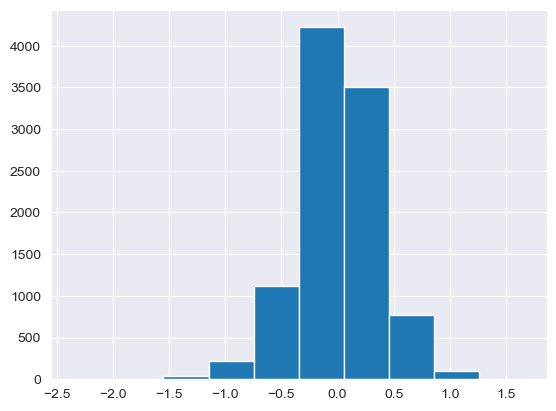

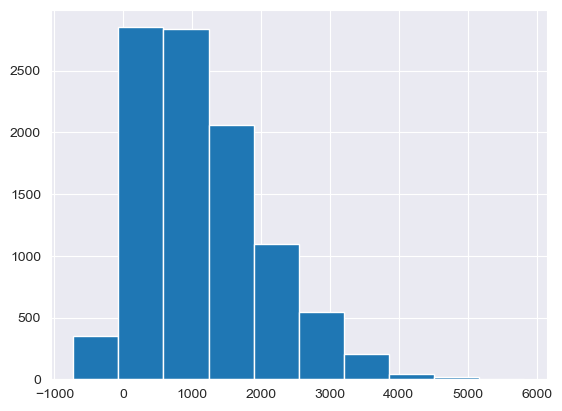

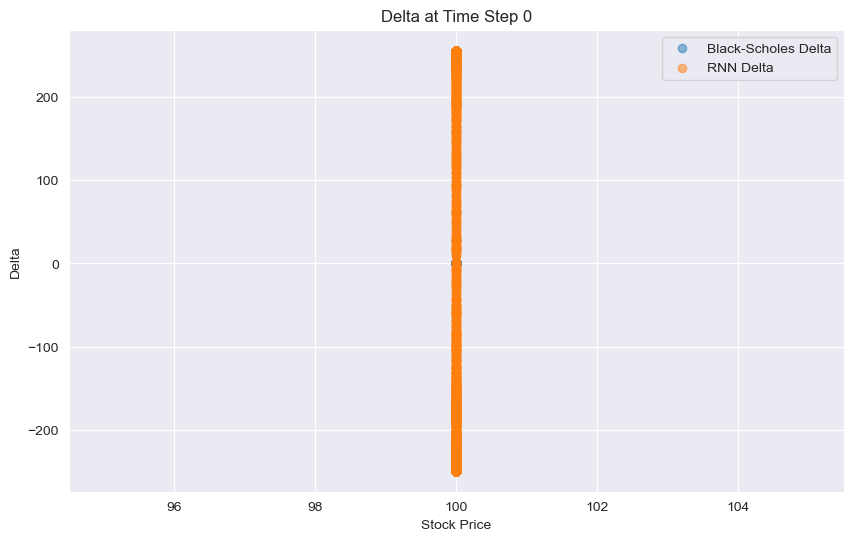

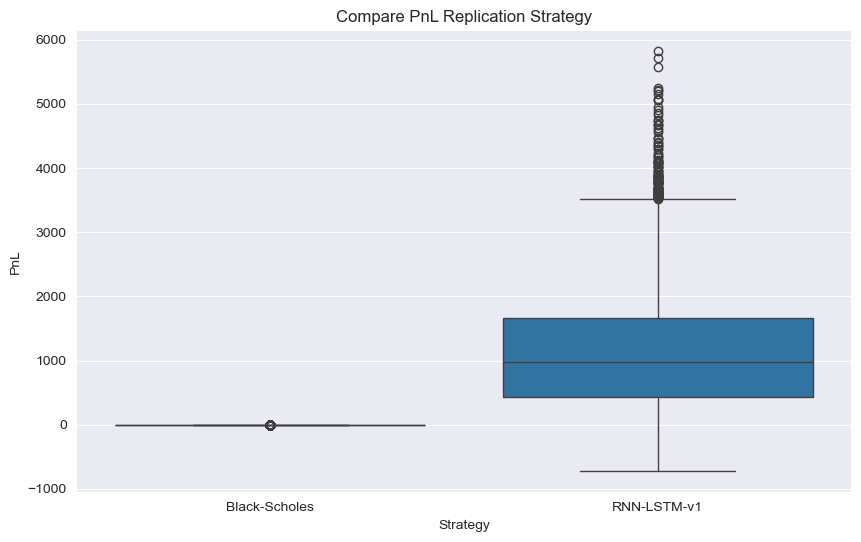

In [18]:
import seaborn as sns

_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test1_results[2], paths_test, K, 2.302974467802428, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

<a id='5.2.2'></a>
### 5.2.2. Changing Moneyness

In [19]:
with tf.compat.v1.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_Moneyness = model_1.predict(paths_test, np.ones(paths_test.shape[1])*(K-10), alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 10.07339936955367
Mean Hedging PnL: 0.00075085717619454
CVaR Hedging PnL: 0.697752677508066
BS price at t0: 10.073
Mean Hedging PnL: 1128.2356449688048
CVaR Hedging PnL: 350.074784810476


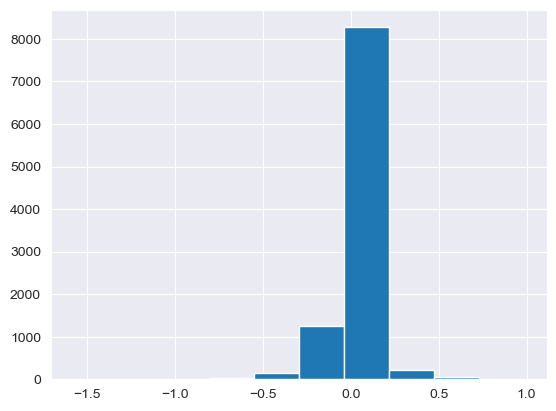

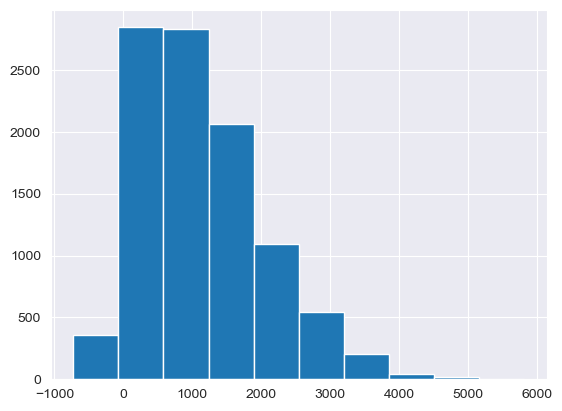

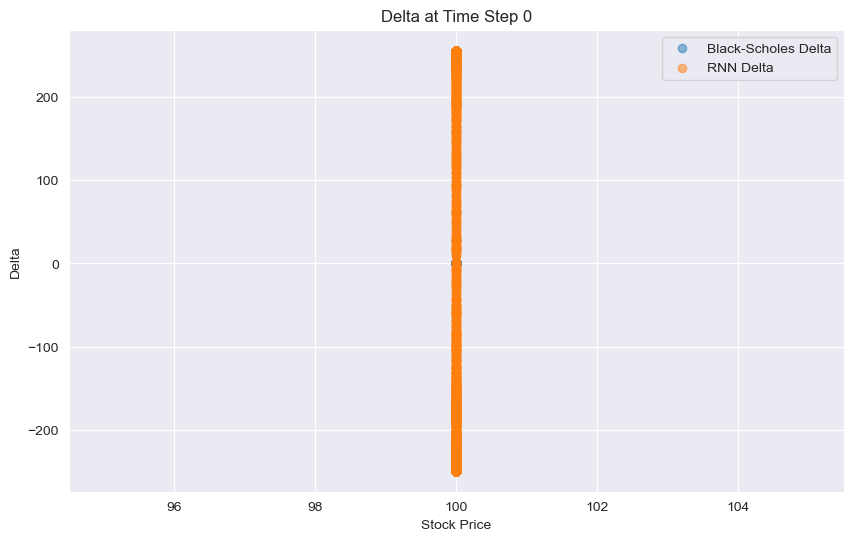

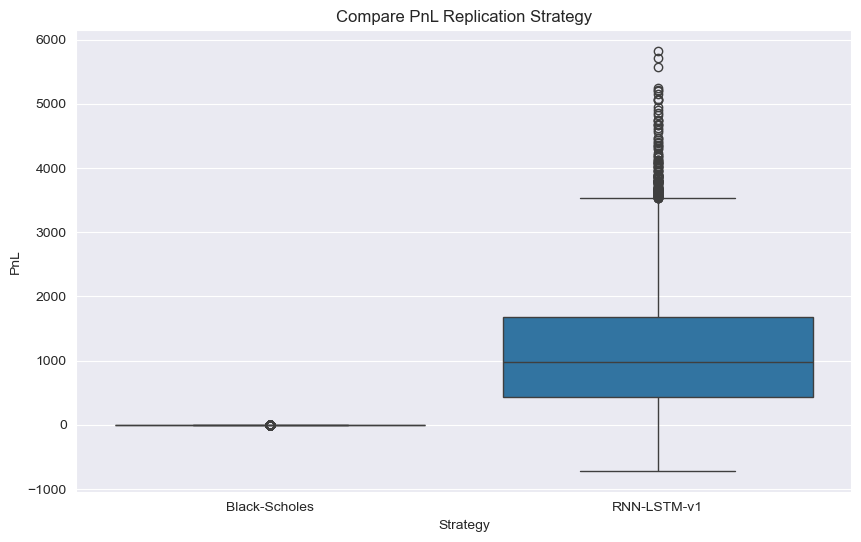

In [20]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K-10, r, vol, T, paths_test, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_Moneyness[2], paths_test, K-10, 10.073, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

<a id='5.2.3'></a>
### 5.2.3. Changing Drift

In [21]:
# Test set 2: Assume the drift of the underlying is 4% per month under the real world measure 
paths_test_drift = monte_carlo_paths(S_0, T, vol, 0.48+r, seed_test, n_sims_test, timesteps)

In [22]:
with tf.compat.v1.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_drift = model_1.predict(paths_test_drift, np.ones(paths_test_drift.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.017239029648273813
CVaR Hedging PnL: 1.214122019938576
BS price at t0: 2.3029
Mean Hedging PnL: 1453.6991336055382
CVaR Hedging PnL: 338.73756878649664


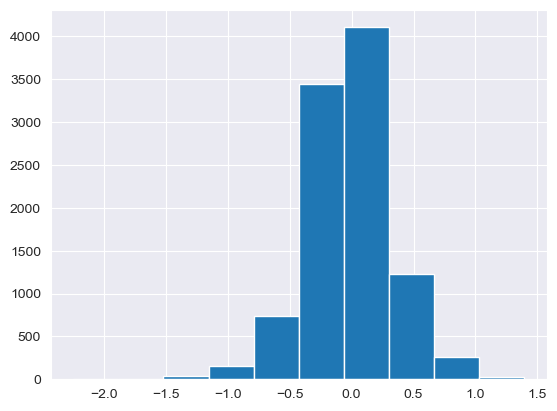

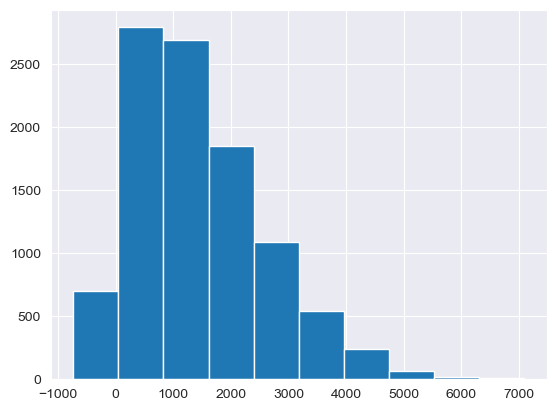

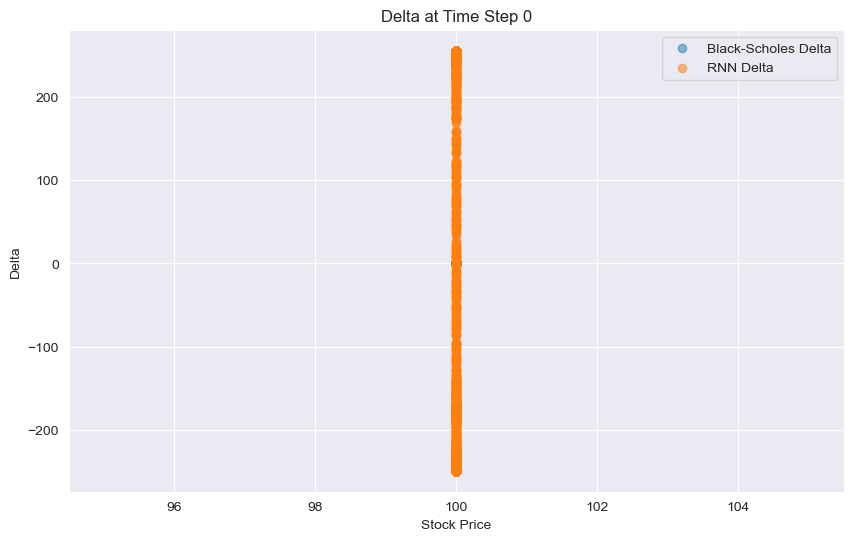

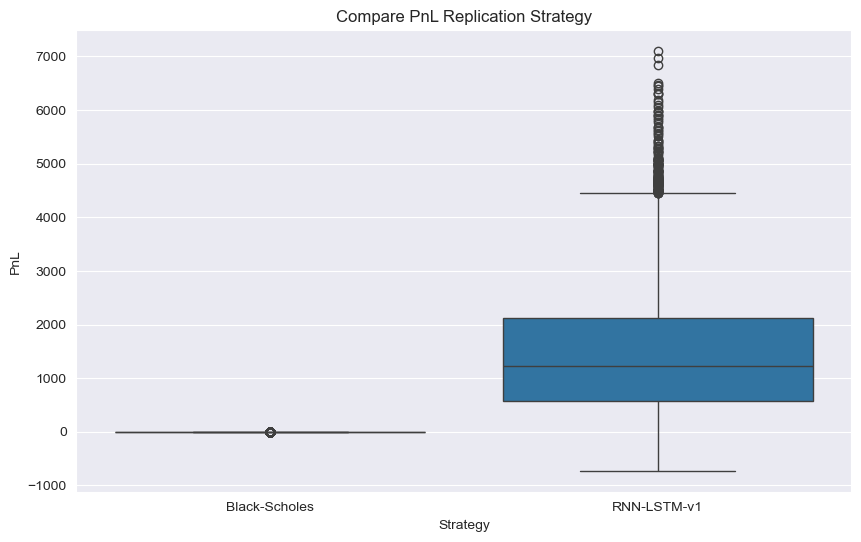

In [23]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K,r, vol, T, paths_test_drift, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_drift[2], paths_test_drift, K, 2.3029, alpha, True)
plot_deltas(paths_test_drift, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

## <a id='5.2.4'></a>
### 5.3.4. Shifted Volatility

In [24]:
# Test set 3: Assume the volatility is not constant and the realized volatility is 5% higher 
# than the implied (historical observed) one
paths_test_vol = monte_carlo_paths(S_0, T, vol+0.05, r, seed_test, n_sims_test, timesteps)

In [25]:
with tf.compat.v1.Session() as sess:
    model_1.restore(sess, 'model.ckpt')
    #Using the model_1 trained in the section above
    test_results_vol = model_1.predict(paths_test_vol, np.ones(paths_test_vol.shape[1])*K, alpha, sess)

INFO:tensorflow:Restoring parameters from model.ckpt


BS price at t0: 2.3029744678024286
Mean Hedging PnL: -0.5787493248269506
CVaR Hedging PnL: 2.5583922824407566
BS price at t0: 2.309
Mean Hedging PnL: 1402.5027803761377
CVaR Hedging PnL: 476.88676675769307


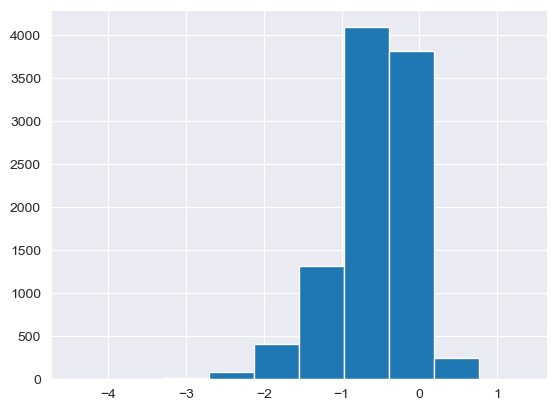

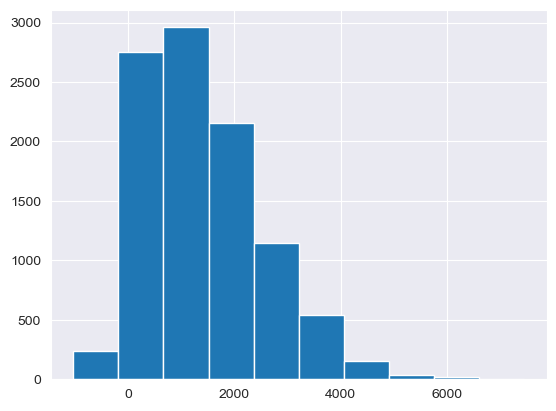

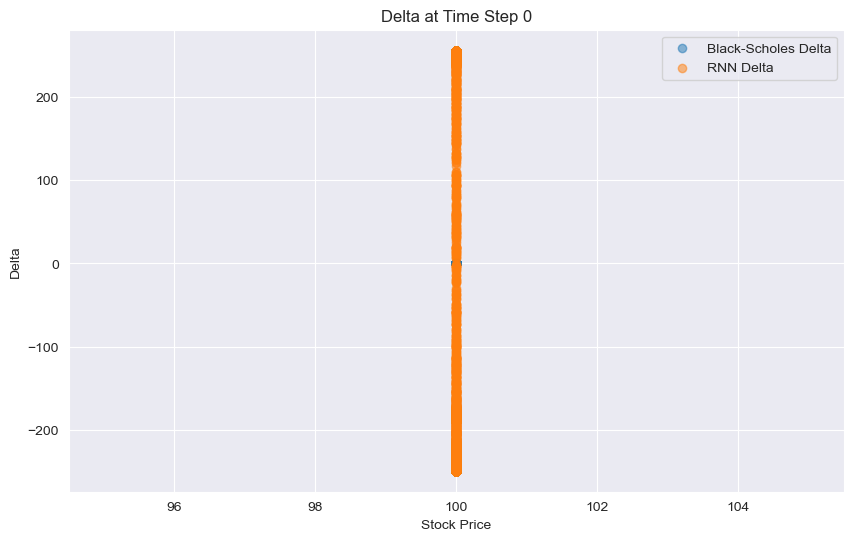

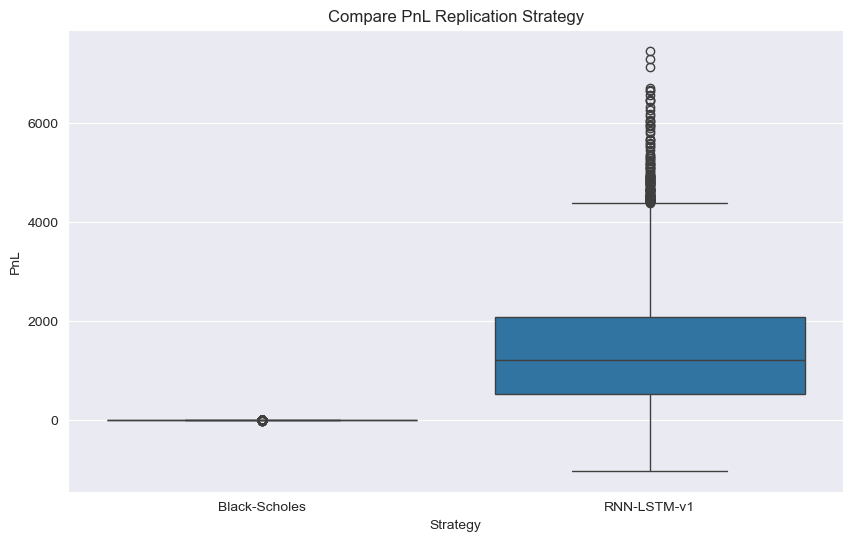

In [26]:
_,_,_,portfolio_pnl_bs, deltas_bs = black_scholes_hedge_strategy(S_0,K, r, vol, T, paths_test_vol, alpha, True)
plt.figure()
_,_,_,portfolio_pnl_rnn, deltas_rnn = test_hedging_strategy(test_results_vol[2], paths_test_vol, K, 2.309, alpha, True)
plot_deltas(paths_test, deltas_bs, deltas_rnn)
plot_strategy_pnl(portfolio_pnl_bs, portfolio_pnl_rnn)

In [27]:
deltas_rnn.shape

(1, 10000)

## Synthèse

La couverture dynamique réduit l'exposition directionnelle mais reste sensible aux frictions et au saut de volatilité. Pour des modèles plus riches (vol stochastique), adapter le générateur de trajectoires et recalibrer la fréquence d'ajustement.
